In [76]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
sns.set(style='whitegrid')

  ## 1. Load raw data

In [77]:

DATA_DIR = Path('/home/arjay55/code/datasets/diabetes+130-us+hospitals+for+years+1999-2008')  # change if files are elsewhere
df = pd.read_csv(DATA_DIR / 'diabetic_data.csv')
ids_map = pd.read_csv(DATA_DIR / 'IDS_mapping.csv')
print(f'Data shape: {df.shape}')
df.head()

Data shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [78]:
# Print columns by data type
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
integer_cols = df.select_dtypes(include=['int64', 'int32']).columns

print("Categorical/Object columns:")
print(f"Count: {len(categorical_cols)}")
print(categorical_cols.tolist())

print("\nInteger columns:")
print(f"Count: {len(integer_cols)}")
print(integer_cols.tolist())

print(f"\nTotal columns analyzed: {len(categorical_cols) + len(integer_cols)}")
print(f"DataFrame shape: {df.shape}")

Categorical/Object columns:
Count: 37
['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

Integer columns:
Count: 13
['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Total columns analyzed: 50
DataFrame shape: (101766, 50)


In [79]:
# convert ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'] to category
categorical_cols = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df[categorical_cols] = df[categorical_cols].astype('category')

categorical_cols_rest = df.select_dtypes(include=['object', 'category']).columns
# convert rest of the categorical columns to category
df[categorical_cols_rest] = df[categorical_cols_rest].astype('category')

In [80]:
def encode_med_change(x):
    """
    Simple ordinal encoder for medication‐change flags. No translates to zero as there is no drug. 
    Down can have the value of 1 as as the probability of relatively lower dosage than is more likely., 2 for steady meaning the drugs are normal,
    3 for up as the probability of relatively higher dosage than is more likely.
    
    Maps:
      "No"     → 0.0
      "Down"   → 1.0
      "Steady" → 2.0
      "Up"     → 3.0
    
    Anything else → np.nan
    """
    mapping = {
        "no":      0.0,
        "down":    1.0,
        "steady":  2.0,
        "up":      3.0,
    }
    # normalize to lower‐case string, then lookup
    return mapping.get(str(x).strip().lower(), np.nan)

In [81]:
# Apply medication change encoding to all medication columns
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone'
]

for col in medication_cols:
    df[col] = df[col].apply(encode_med_change)

print(f"Applied medication change encoding to {len(medication_cols)} columns")
print("Sample encoded values:")
print(df[medication_cols[:5]].head())
   

Applied medication change encoding to 23 columns
Sample encoded values:
  metformin repaglinide nateglinide chlorpropamide glimepiride
0       0.0         0.0         0.0            0.0         0.0
1       0.0         0.0         0.0            0.0         0.0
2       0.0         0.0         0.0            0.0         0.0
3       0.0         0.0         0.0            0.0         0.0
4       0.0         0.0         0.0            0.0         0.0


In [82]:
# Drop weight as 97% have missing weights and drop impossible genders
df = df[df['gender'] != 'Unknown/Invalid'].copy()
df.drop(columns=['weight'], inplace=True)
freq = df["patient_nbr"].value_counts(normalize=True) # Calculate frequency of each patient. More frequent patients are more likely to have chronic conditions.
df["patient_freq"] = df["patient_nbr"].map(freq)

# Drop patient_nbr as it is not useful for modeling anymore
df.drop(columns=['patient_nbr'], inplace=True)

# Replace '?' with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].replace('?', 'Unknown')

# Remove encounters with discharge disposition indicating death/hospice
hospice_codes = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(hospice_codes)]


In [83]:
# 2. Compute proportions
freq = df['discharge_disposition_id'].value_counts(normalize=True)

# 3. Select “major” IDs (≥1% of all records)
major_ids = set(freq[freq >= 0.01].index)

# 4. Map to reduced categories
def bucket_disp(x):
    return x if x in major_ids else 'Other'

df['disch_reduced'] = df['discharge_disposition_id'].apply(bucket_disp)
# df_pt['disch_reduced'] = df_pt['discharge_disposition_id'].apply(bucket_disp)

# 5. Drop original column
df.drop(columns=['discharge_disposition_id'], inplace=True)
# 6. Dummify the reduced column
df = pd.get_dummies(df, columns=['disch_reduced'], drop_first=True)

  ### 2.1 Map admission/disposition/source IDs
  * Translates IDs to descriptions for easier analysis

In [91]:
# Create mapping for admission_type_id only (since that's what we have)
def build_mapping_from_df(df_map):
    # Remove any rows with NaN values
    df_clean = df_map.dropna()
    return dict(zip(df_clean['admission_type_id'], df_clean['description']))

# Build the admission type mapping
admission_type_mapping = build_mapping_from_df(ids_map)

original_dtype = df['admission_type_id'].dtype

# Create new mapping with converted keys
if original_dtype in ['int64', 'int32', 'float64', 'category']:
    # Convert string keys to numeric
    admission_type_mapping_fixed = {
        int(k): v for k, v in admission_type_mapping.items() 
        if k.isdigit()
    }
else:
    # Keep as strings
    admission_type_mapping_fixed = admission_type_mapping

# Apply the mapping
df['admission_type_id'] = df['admission_type_id'].map(admission_type_mapping_fixed)
# df_pt['admission_type_id'] = df_pt['admission_type_id'].map(admission_type_mapping_fixed).fillna('Other')
print("After applying mapping with converted keys:")
print(df['admission_type_id'].value_counts())

After applying mapping with converted keys:
admission_type_id
 Physician Referral                                52882
HMO Referral                                       18738
Clinic Referral                                    18226
 Transfer from another health care facility         5227
 Transfer from a Skilled Nursing Facility (SNF)     4690
 Court/Law Enforcement                               320
 Emergency Room                                       18
Transfer from a hospital                              10
Name: count, dtype: int64


  ### 2.2 Aggregate ICD‑9 diagnosis codes
* First if statement are focused on internal, coronary and diabetic diseases, which could have comorbidities with each other, and thus we choose to make this detailed.
* Other diseases are grouped, as they can have of less influence.

In [ ]:

def diag_category(icd):
    try:
        icd = str(icd)
        code = icd.split('.')[0]  # take 3‑digit root
        if code.startswith('V') or code.startswith('E'):
            return 'Other'
        code = int(code)
    except:
        return 'Other'
    if 390 <= code <= 459 or code == 785 or 460 <= code <= 519 or code == 786 or 520 <= code <= 579 or code == 787 or 250 <= code <= 251:
        return f'icd_{code}'  # will result to very sparse categories
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 140 <= code <= 239:
        return 'Neoplasms'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_cat'] = df[col].apply(diag_category)
    # df_pt[f'{col}_cat'] = df_pt[col].apply(diag_category)

df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)
# df_pt.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)

encounter_id has no relevance in the study

In [12]:

df.drop(columns=['encounter_id'], inplace=True, errors='ignore')

In [ ]:
df_pt = df.copy() # for Pytorch Tabular

  ## 3. Train‑test split & preprocessing

In [13]:
def clean_column_name(col_name):
    """Clean column names by removing special characters that XGBoost doesn't allow"""
    return str(col_name).replace('[', '_').replace(']', '_').replace('<', '_lt_').replace('>', '_gt_').replace(',', '_')

In [14]:

y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

X_train, X_test, y_train, y_test = train_test_split( #stratified sampling
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('Train size:', X_train.shape, 'Pos rate:', y_train.mean().round(3))
print('Test size:', X_test.shape, 'Pos rate:', y_test.mean().round(3))

# Fix column names to remove special characters that XGBoost doesn't allow
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Train size: (70077, 53) Pos rate: 0.113
Test size: (30034, 53) Pos rate: 0.113


  ### 3.1 Balance training set by random oversampling

In [15]:

train = pd.concat([X_train, y_train], axis=1)
maj = train[train['readmitted']==0]
minu = train[train['readmitted']==1]
minu_upsampled = resample(minu, replace=True, n_samples=len(maj), random_state=1803)
train_bal = pd.concat([maj, minu_upsampled])
X_train_bal = train_bal.drop(columns=['readmitted'])
y_train_bal = train_bal['readmitted']
print('Balanced class counts:', y_train_bal.value_counts())

Balanced class counts: readmitted
0    62127
1    62127
Name: count, dtype: int64


  ### 3.2 One‑hot encode categorical variables

In [16]:

# categorical features ("object" dtype) are dummified, meaning they are converted to one-hot encoded columns.
cat_feats = X_train_bal.select_dtypes(include=['object','category']).columns
X_train_bal_enc = pd.get_dummies(X_train_bal, columns=cat_feats, drop_first=True) # reduce collinearity
X_test_enc = pd.get_dummies(X_test, columns=cat_feats, drop_first=True) # reduce collinearity
X_train_bal_enc, X_test_enc = X_train_bal_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

## haircut for it to be compatible with XGBoost
X_train_bal_enc.columns = [clean_column_name(col) for col in X_train_bal_enc.columns]
X_test_enc.columns = [clean_column_name(col) for col in X_test_enc.columns]

# Apply standard scaling to numeric features
num_feats = X_train_bal_enc.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train_bal_enc[num_feats] = scaler.fit_transform(X_train_bal_enc[num_feats])
X_test_enc[num_feats] = scaler.transform(X_test_enc[num_feats])

print("Feature engineering for baseline runs completed.")
# Dummify categorical variables for X_train and X_test

print("Creating dummy variables for training and test sets for pipeline use...")

# Get categorical columns
cat_cols = X_train.select_dtypes(include=['object','category']).columns
print(f"Categorical columns to encode: {list(cat_cols)}")



# Dummify X_train and X_test
X_train = pd.get_dummies(X_train, columns=cat_feats, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)

scaler = StandardScaler() # normalize!
X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
X_test[num_feats] = scaler.transform(X_test[num_feats])
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Clean column names for XGBoost compatibility
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Feature engineering for baseline runs completed.
Creating dummy variables for training and test sets for pipeline use...
Categorical columns to encode: ['race', 'gender', 'age', 'admission_type_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat']


  ## 4. Model training

In [17]:

print("Initializing models...")
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=1803)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1803)
xgb = XGBClassifier(n_estimators=100, max_depth=6, eval_metric='logloss',
                    use_label_encoder=False, verbosity=0, random_state=1803)

print("Training Logistic Regression...")
logreg.fit(X_train_bal_enc, y_train_bal)
print("Training Random Forest...")
rf.fit(X_train_bal_enc, y_train_bal)
print("Training XGBoost...")
xgb.fit(X_train_bal_enc, y_train_bal)

Initializing models...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:

def eval_model(name, model):
    y_pred = model.predict(X_test_enc)
    y_prob = model.predict_proba(X_test_enc)[:,1]
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:20} Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC: {auc:.3f} Accuracy: {acc:.3f}")
    return y_pred

preds = {}
preds['Logistic'] = eval_model('Logistic Regression', logreg)
preds['RandomForest'] = eval_model('Random Forest', rf)
preds['XGBoost'] = eval_model('XGBoost', xgb)

Logistic Regression  Precision: 0.221 Recall: 0.587 F1: 0.321 ROC-AUC: 0.723 Accuracy: 0.719
Random Forest        Precision: 0.204 Recall: 0.733 F1: 0.320 ROC-AUC: 0.739 Accuracy: 0.646
XGBoost              Precision: 0.236 Recall: 0.732 F1: 0.358 ROC-AUC: 0.779 Accuracy: 0.701


* Results show suboptimal performance. The class imbalance is significant, due to small positivity rate of 0.113.
* We will proceed with XGBOOST due to its versatility and a go-to algorithm for tabular data.
* We will use optuna as a hyperparameter tuning tool, a generic hyperparameter tuning framework.

In [19]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Create pipeline with proper order: preprocess -> balance -> model (with Optuna parameters)
def create_model_pipeline(trial=None):
    
    # If trial is provided, optimize hyperparameters
    if trial is not None:
        # Optuna hyperparameter suggestions for XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
        
        classifier = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            eval_metric='logloss',
            use_label_encoder=False,
            verbosity=0,
            random_state=1803,
            n_jobs=10  # Use all available cores
        )
    else:
        # Use default/best known parameters for XGBoost
        classifier = XGBClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric='logloss', use_label_encoder=False,
            verbosity=0, random_state=1803
        )
    rng = np.random.default_rng()
    pipeline = ImbPipeline([ 
        ('balancer', SMOTE(random_state=rng.integers(2**16))), # pipeline performs oversampling per each fold, avoiding data leakage
        ('classifier', classifier)
    ])
    return pipeline

# Optuna objective function
def objective(trial):
    # Create pipeline with trial parameters
    pipeline = create_model_pipeline(trial)
    
    # Cross-validation with proper data handling

    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=4,  
        scoring='accuracy',
        n_jobs=1  # Reduced to prevent system overload
    )
    
    return cv_scores.mean()

# Run Optuna optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1803)
)

# Optimize with progress callback
# def callback(study, trial):
#     if trial.number % 5 == 0:
#         print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")

study.optimize(
    objective, 
    n_trials=100,
    # callbacks=[callback],
    show_progress_bar=True,
)

# Print optimization results
print(f"\nOptimization completed!")
print(f"Best parameters: {study.best_params}")
print(f"Best CV accuracy score: {study.best_value:.4f}")

# Create final pipeline with best parameters
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Final CV accuracy score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")

[I 2025-06-22 21:30:20,411] A new study created in memory with name: no-name-303ac3d7-b314-48be-99be-2cb2055f9c1f


Starting Optuna hyperparameter optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-22 21:30:49,973] Trial 0 finished with value: 0.8788618353628325 and parameters: {'n_estimators': 164, 'max_depth': 15, 'learning_rate': 0.21191694474081635, 'subsample': 0.6904437683143655, 'colsample_bytree': 0.8618698714066619, 'reg_alpha': 0.3962959879812257, 'reg_lambda': 0.909399760281288}. Best is trial 0 with value: 0.8788618353628325.
[I 2025-06-22 21:31:41,297] Trial 1 finished with value: 0.8775632607363538 and parameters: {'n_estimators': 309, 'max_depth': 13, 'learning_rate': 0.013593797341396345, 'subsample': 0.7425593088977969, 'colsample_bytree': 0.9273841019764437, 'reg_alpha': 0.3435138821068924, 'reg_lambda': 0.29783633190422765}. Best is trial 0 with value: 0.8788618353628325.
[I 2025-06-22 21:32:55,970] Trial 2 finished with value: 0.8778058349434573 and parameters: {'n_estimators': 513, 'max_depth': 14, 'learning_rate': 0.21957825505770912, 'subsample': 0.7201632969976054, 'colsample_bytree': 0.9336080058865639, 'reg_alpha': 0.3499472600676322, 'reg_lam

In [20]:
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params,random_state=1803)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Final CV accuracy score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")


Training final model with best parameters...
Final CV accuracy score: 0.886 ± 0.001


In [21]:
# Train the final model on all training data
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('balancer', SMOTE(random_state=21826)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7905921798819306, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0788904684410345, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=677,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [22]:
# Evaluate on test set
y_pred_test = best_pipeline.predict(X_test)
y_prob_test = best_pipeline.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_prob_test)

print(f"\nFinal Test Performance:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"F1: {test_f1:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

# Save the best model for later use
best_rf_optimized = best_pipeline.named_steps['classifier']


Final Test Performance:
Accuracy: 0.887
F1: 0.101
Precision: 0.514
Recall: 0.056
ROC-AUC: 0.783


* Accuracy was well achieved. However the lack of data for readmissions resulted in highly skewed result plus some other modeling imperfections. The model is not yet safe for deployment. A higher recall is better. Class weighting that biases on readmission rates will be better.

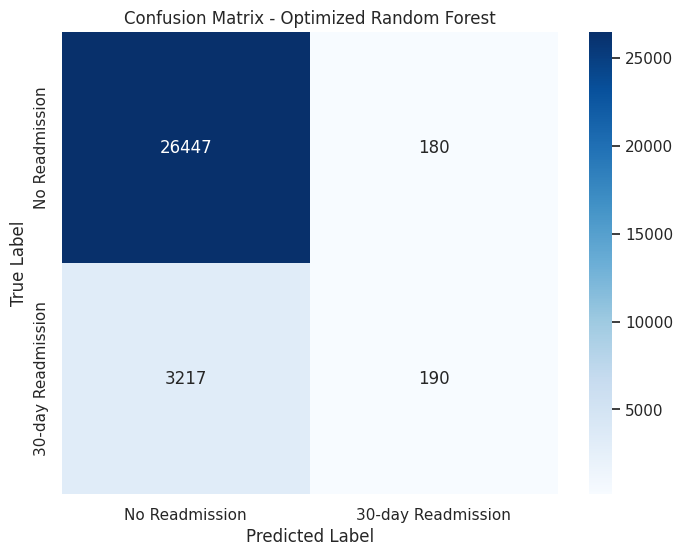

In [23]:

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [24]:
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")


Confusion Matrix:
True Negatives: 26447
False Positives: 180
False Negatives: 3217
True Positives: 190


In [25]:
study.best_params

{'n_estimators': 677,
 'max_depth': 5,
 'learning_rate': 0.0788904684410345,
 'subsample': 0.8244269635087204,
 'colsample_bytree': 0.7905921798819306,
 'reg_alpha': 0.7023795461588158,
 'reg_lambda': 0.4852405347816829}

# PyTorch Tabular Implementation

Now we'll implement the same training pipeline using PyTorch Tabular with neural networks instead of XGBoost. Pytorch Tabular aims to implement suitable neural network architectures for tabular data with ease of use in using other popular frameworks, like Pandas.

In [26]:
# Import PyTorch Tabular
import torch
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

print("PyTorch Tabular imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch Tabular imported successfully
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti


In [31]:
# Prepare data for PyTorch Tabular
# We'll use the same train/test split as XGBoost but with different preprocessing
print("Preparing data for PyTorch Tabular...")

# Start with the original X_train, X_test, y_train, y_test
# Reset from the original data before one-hot encoding
y = (df_pt['readmitted'] == '<30').astype(int)
X = df_pt.drop(columns=['readmitted'])

X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('PyTorch Tabular - Train size:', X_train_pt.shape, 'Pos rate:', y_train_pt.mean().round(3))
print('PyTorch Tabular - Test size:', X_test_pt.shape, 'Pos rate:', y_test_pt.mean().round(3))

# Clean column names
X_train_pt.columns = [clean_column_name(col) for col in X_train_pt.columns]
X_test_pt.columns = [clean_column_name(col) for col in X_test_pt.columns]

train_df_pt = X_train_pt.copy()
train_df_pt["target"] = y_train_pt.values
print("Data prepared for PyTorch Tabular")

Preparing data for PyTorch Tabular...
PyTorch Tabular - Train size: (71236, 50) Pos rate: 0.112
PyTorch Tabular - Test size: (30530, 50) Pos rate: 0.112
Data prepared for PyTorch Tabular


In [32]:
# Balance training set by random oversampling (same as XGBoost)
print("Balancing training data...")

maj_pt = train_df_pt[train_df_pt['target']==0]
minu_pt = train_df_pt[train_df_pt['target']==1]
minu_upsampled_pt = resample(minu_pt, replace=True, n_samples=len(maj_pt), random_state=1803)
train_bal_df_pt = pd.concat([maj_pt, minu_upsampled_pt])

print('Balanced class counts for PyTorch Tabular:', train_bal_df_pt['target'].value_counts())
print('Balanced training set shape:', train_bal_df_pt.shape)

Balancing training data...
Balanced class counts for PyTorch Tabular: target
0    63286
1    63286
Name: count, dtype: int64
Balanced training set shape: (126572, 51)


In [33]:
# Define categorical and numerical columns for PyTorch Tabular
categorical_cols_pt = [col for col in X_train_pt.columns if X_train_pt[col].dtype == 'object' or X_train_pt[col].dtype.name == 'category']
numerical_cols_pt = [col for col in X_train_pt.columns if X_train_pt[col].dtype != 'object' and X_train_pt[col].dtype.name != 'category']

print(f"Categorical columns ({len(categorical_cols_pt)}): {categorical_cols_pt[:5]}...")
print(f"Numerical columns ({len(numerical_cols_pt)}): {numerical_cols_pt[:5]}...")

# Make sure we have the correct categoricals
categorical_cols_pt = []
numerical_cols_pt = []

for col in X_train_pt.columns:
    if X_train_pt[col].dtype == 'object' or str(X_train_pt[col].dtype) == 'category':
        categorical_cols_pt.append(col)
    else:
        numerical_cols_pt.append(col)

# Dummify categorical columns for PyTorch Tabular
# X_train_pt = pd.get_dummies(X_train_pt, columns=categorical_cols_pt, drop_first=True)
# X_test_pt = pd.get_dummies(X_test_pt, columns=categorical_cols_pt, drop_first=True)

scaler = StandardScaler()
# Normalize numerical columns for PyTorch Tabular
X_train_pt[numerical_cols_pt] = scaler.fit_transform(X_train_pt[numerical_cols_pt])
X_test_pt[numerical_cols_pt] = scaler.transform(X_test_pt[numerical_cols_pt])
X_train_pt, X_test_pt = X_train_pt.align(X_test_pt, join='left', axis=1, fill_value=0)

# Add target column to create complete datasets
train_df_pt = X_train_pt.copy()
train_df_pt['target'] = y_train_pt.values

test_df_pt = X_test_pt.copy()
test_df_pt['target'] = y_test_pt.values

# Configure PyTorch Tabular Data Config
data_config = DataConfig(
    target=['target'],  # Target column
    continuous_cols=numerical_cols_pt,  # Numerical columns
    categorical_cols=categorical_cols_pt,  # Categorical columns
    normalize_continuous_features=True,  # Similar to StandardScaler
)

print("PyTorch Tabular Data Config created successfully")

Categorical columns (42): ['encounter_id', 'patient_nbr', 'race', 'gender', 'age']...
Numerical columns (8): ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient']...
PyTorch Tabular Data Config created successfully


* We will use CategoryEmbeddingModelConfig, where categorical data are transformed into high dimensional embeddings.
* We will go through the process of trying the model incrementally prior to proceeding to hyperparameter tuning.

In [34]:
# Create baseline PyTorch Tabular model configuration
model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="128-64-32",  # Neural network architecture
    activation="ReLU",
    dropout=0.1,
    use_batch_norm=True,  # Correct parameter name
    learning_rate=1e-3,
    seed=1803,
)

trainer_config = TrainerConfig(
    batch_size=1024,
    max_epochs=50,
    early_stopping="valid_loss",
    early_stopping_patience=10,
    checkpoints=None,  # Disable checkpoints to avoid loading issues
    load_best=False,   # Don't try to load best model
    progress_bar="none",  # Disable progress bar for cleaner output
    auto_lr_find=False,  # We'll set learning rate manually
    auto_select_gpus=torch.cuda.is_available(),
    seed=1803,
)

optimizer_config = OptimizerConfig()

print("PyTorch Tabular configurations created successfully")

PyTorch Tabular configurations created successfully


In [35]:
# Train baseline PyTorch Tabular model
print("Training baseline PyTorch Tabular model...")

baseline_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

# Fit the model
baseline_model.fit(train=train_bal_df_pt, validation=test_df_pt)

print("Baseline PyTorch Tabular model training completed")

Training baseline PyTorch Tabular model...


2025-06-22 23:03:07,795 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:03:08,525 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:03:09,042 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:03:10,508 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:03:10,784 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:03:10,797 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 65.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 6.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.415    Total estimated model par

2025-06-22 23:04:01,719 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Baseline PyTorch Tabular model training completed


In [37]:
# Evaluate baseline PyTorch Tabular model
print("Evaluating baseline PyTorch Tabular model...")

# Make predictions
baseline_pred_proba = baseline_model.predict(test_df_pt)
print("Prediction output shape:", baseline_pred_proba.shape)
print("Prediction output columns:", baseline_pred_proba.columns.tolist())

# Get prediction probabilities - use the correct column name
if '1' in baseline_pred_proba.columns:
    baseline_proba_values = baseline_pred_proba['1'].values
elif '1_probability' in baseline_pred_proba.columns:
    baseline_proba_values = baseline_pred_proba['1_probability'].values
else:
    # Try the first numeric column after the identifier columns
    prob_cols = [col for col in baseline_pred_proba.columns if col not in ['patient_nbr', 'target']]
    baseline_proba_values = baseline_pred_proba[prob_cols[0]].values

baseline_pred = (baseline_proba_values > 0.5).astype(int)

# Calculate metrics
baseline_prec = precision_score(y_test_pt, baseline_pred)
baseline_rec = recall_score(y_test_pt, baseline_pred)
baseline_f1 = f1_score(y_test_pt, baseline_pred)
baseline_auc = roc_auc_score(y_test_pt, baseline_proba_values)

print(f"Baseline PyTorch Tabular Performance:")
print(f"Precision: {baseline_prec:.3f}")
print(f"Recall: {baseline_rec:.3f}")
print(f"F1: {baseline_f1:.3f}")
print(f"ROC-AUC: {baseline_auc:.3f}")
print (f"Accuracy: {accuracy_score(y_test_pt, baseline_pred):.3f}")

Evaluating baseline PyTorch Tabular model...
Prediction output shape: (30530, 3)
Prediction output columns: ['target_0_probability', 'target_1_probability', 'target_prediction']
Baseline PyTorch Tabular Performance:
Precision: 0.110
Recall: 0.977
F1: 0.198
ROC-AUC: 0.381
Accuracy: 0.116


* Results are suboptimal, will proceed to k-fold validation

In [38]:
# Implement 4-fold cross-validation for PyTorch Tabular
from sklearn.model_selection import StratifiedKFold
import pickle
import tempfile
import os

def pytorch_tabular_cv(X_data, y_data, n_folds=4, model_params=None):
    """
    Perform cross-validation for PyTorch Tabular model
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1803)
    cv_scores = []
    
    # Combine X and y for easier handling
    full_data = X_data.copy()
    full_data['target'] = y_data.values
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
        print(f"Training fold {fold + 1}/{n_folds}...")
        
        # Split data
        train_fold = full_data.iloc[train_idx]
        val_fold = full_data.iloc[val_idx]
        
        # Balance training fold
        maj_fold = train_fold[train_fold['target']==0]
        minu_fold = train_fold[train_fold['target']==1]
        minu_upsampled_fold = resample(minu_fold, replace=True, n_samples=len(maj_fold), random_state=1803+fold)
        train_fold_balanced = pd.concat([maj_fold, minu_upsampled_fold])
        
        # Create model configuration
        if model_params is None:
            fold_model_config = CategoryEmbeddingModelConfig(
                task="classification",
                layers="128-64-32",
                activation="ReLU", 
                dropout=0.1,
                use_batch_norm=True,  # Fixed parameter name
                learning_rate=1e-3,
                seed=1803+fold,
            )
        else:
            fold_model_config = CategoryEmbeddingModelConfig(
                task="classification",
                **model_params,
                seed=1803+fold,
            )
        
        fold_trainer_config = TrainerConfig(
            batch_size=1024,
            max_epochs=30,  # Reduced for CV
            early_stopping="valid_loss",
            early_stopping_patience=5,
            checkpoints=None,  # Don't save checkpoints for CV
            load_best=True,   # Don't try to load best model
            progress_bar="none",
            auto_lr_find=False,
            auto_select_gpus=torch.cuda.is_available(),
            seed=1803+fold,
        )
        
        # Create and train model
        fold_model = TabularModel(
            data_config=data_config,
            model_config=fold_model_config,
            optimizer_config=optimizer_config,
            trainer_config=fold_trainer_config,
        )
        
        try:
            # Train model
            fold_model.fit(train=train_fold_balanced, validation=val_fold)
            
            # Predict and evaluate
            val_pred_proba = fold_model.predict(val_fold)
            # Use correct column name for predictions
            val_proba_values = val_pred_proba['target_1_probability'].values
            val_pred = (val_proba_values > 0.5).astype(int)
            val_accuracy = accuracy_score(val_fold['target'], val_pred)
            cv_scores.append(val_accuracy)
            
            print(f"Fold {fold + 1} accuracy score: {val_accuracy:.3f}")
            
        except Exception as e:
            print(f"Error in fold {fold + 1}: {e}")
            cv_scores.append(0.0)  # Add poor score for failed fold
    
    return cv_scores


In [39]:

# Perform 4-fold cross-validation with baseline model
print("Performing 4-fold cross-validation with PyTorch Tabular...")
cv_scores_pt = pytorch_tabular_cv(X_train_pt, y_train_pt, n_folds=4)

print(f"\nPyTorch Tabular CV Results:")
print(f"Mean Accuracy: {np.mean(cv_scores_pt):.3f} ± {np.std(cv_scores_pt):.3f}")
print(f"Individual fold scores: {[f'{score:.3f}' for score in cv_scores_pt]}")

Performing 4-fold cross-validation with PyTorch Tabular...
Training fold 1/4...


2025-06-22 23:05:19,502 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:05:19,523 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:05:19,912 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:05:21,031 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:05:21,231 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:05:21,242 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 64.8 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.8 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.582    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:05:50,997 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:05:50,999 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 1 accuracy score: 0.808
Training fold 2/4...


2025-06-22 23:05:51,460 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:05:51,481 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:05:51,863 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:05:52,946 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:05:53,168 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:05:53,178 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 64.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.8 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.567    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:06:25,521 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:06:25,523 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 2 accuracy score: 0.703
Training fold 3/4...


2025-06-22 23:06:25,959 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:06:25,981 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:06:26,343 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:06:27,446 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:06:27,648 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:06:27,658 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 64.8 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.8 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.591    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:06:52,034 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:06:52,036 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 3 accuracy score: 0.769
Training fold 4/4...


2025-06-22 23:06:52,543 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:06:52,563 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:06:52,929 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:06:54,016 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:06:54,213 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:06:54,223 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 64.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.8 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.593    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:07:21,570 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:07:21,571 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 4 accuracy score: 0.838

PyTorch Tabular CV Results:
Mean Accuracy: 0.779 ± 0.050
Individual fold scores: ['0.808', '0.703', '0.769', '0.838']


* Accuracies are suboptimal. Hopefully hyperparameter tuning will enhance this.
* In this case, layer depths, activation, batch sizes, etc will be modified.

In [40]:
# Hyperparameter tuning for PyTorch Tabular using Optuna
import optuna

def pytorch_tabular_objective(trial):
    """
    Optuna objective function for PyTorch Tabular hyperparameter optimization
    """
    # Suggest hyperparameters
    layers_depth = trial.suggest_int('layers_depth', 2, 4)
    layer_size = trial.suggest_categorical('layer_size', [64, 128, 256, 512])
    
    # Create layer string
    if layers_depth == 2:
        layers = f"{layer_size}-{layer_size//2}"
    elif layers_depth == 3:
        layers = f"{layer_size}-{layer_size//2}-{layer_size//4}"
    else:  # layers_depth == 4
        layers = f"{layer_size}-{layer_size//2}-{layer_size//4}-{layer_size//8}"
    
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [512, 1024, 2048])
    activation = trial.suggest_categorical('activation', ['ReLU', 'GELU', 'LeakyReLU'])
    
    # Model parameters
    model_params = {
        'layers': layers,
        'activation': activation,
        'dropout': dropout,
        'use_batch_norm': True,  # Fixed parameter name
        'learning_rate': learning_rate,
    }
    
    # Use trainer config with suggested batch size
    global data_config, optimizer_config
    
    # Perform cross-validation with reduced folds for speed
    cv_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1803)  # Reduced to 3 folds for speed
    
    # Combine X and y for easier handling
    full_data = X_train_pt.copy()
    full_data['target'] = y_train_pt.values
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_pt, y_train_pt)):
        # Split data
        train_fold = full_data.iloc[train_idx]
        val_fold = full_data.iloc[val_idx]
        
        # Balance training fold
        maj_fold = train_fold[train_fold['target']==0]
        minu_fold = train_fold[train_fold['target']==1]
        minu_upsampled_fold = resample(minu_fold, replace=True, n_samples=len(maj_fold))
        train_fold_balanced = pd.concat([maj_fold, minu_upsampled_fold])
        
        # Create model configuration
        fold_model_config = CategoryEmbeddingModelConfig(
            task="classification",
            **model_params,
            seed=1803+fold,
        )
        
        fold_trainer_config = TrainerConfig(
            batch_size=batch_size,
            max_epochs=20,  # Reduced for hyperparameter tuning
            early_stopping="valid_loss",
            early_stopping_patience=3,
            checkpoints=None,
            load_best=False,
            progress_bar="none",
            auto_lr_find=False,
            auto_select_gpus=torch.cuda.is_available(),
            seed=1803+fold,
        )
        
        # Create and train model
        fold_model = TabularModel(
            data_config=data_config,
            model_config=fold_model_config,
            optimizer_config=optimizer_config,
            trainer_config=fold_trainer_config,
        )
        
        try:
            # Train model
            fold_model.fit(train=train_fold_balanced, validation=val_fold)
            
            # Predict and evaluate
            val_pred_proba = fold_model.predict(val_fold)
            val_proba_values = val_pred_proba['target_1_probability'].values
            val_pred = (val_proba_values > 0.5).astype(int)
            val_accuracy = accuracy_score(val_fold['target'], val_pred)
            cv_scores.append(val_accuracy)
            
        except Exception as e:
            print(f"Error in fold {fold}: {e}")
            return 0.0  # Return poor score for failed trials
    
    if len(cv_scores) == 0:
        return 0.0
    
    return np.mean(cv_scores)

# Run Optuna optimization for PyTorch Tabular (smaller trial for speed)
print("Starting Optuna hyperparameter optimization for PyTorch Tabular...")
study_pt = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1803)
)

study_pt.optimize(
    pytorch_tabular_objective, 
    n_trials=50,  
    show_progress_bar=True,
)

# Print optimization results
print(f"\nPyTorch Tabular Optimization completed!")
print(f"Best parameters: {study_pt.best_params}")
print(f"Best CV accuracy score: {study_pt.best_value:.4f}")

[I 2025-06-22 23:08:44,000] A new study created in memory with name: no-name-9b2d4b7f-2c42-4386-a008-43bfd20d114f


Starting Optuna hyperparameter optimization for PyTorch Tabular...


  0%|          | 0/50 [00:00<?, ?it/s]

2025-06-22 23:08:44,057 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:08:44,268 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:08:44,591 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:08:45,579 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:08:45,741 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:08:45,743 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:08:45,744 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:08:45,746 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:08:45,773 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:08:45,783 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:08:55,923 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:08:57,035 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:08:57,055 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:08:57,392 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:08:58,379 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:08:58,546 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:08:58,548 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:08:58,550 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:08:58,552 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:08:58,579 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:08:58,589 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:09:08,721 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:09:09,263 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:09:09,284 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:09:09,613 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:09:10,625 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:09:10,829 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:09:10,831 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:09:10,833 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:09:10,835 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:09:10,862 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:09:10,872 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:09:26,461 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:09:26,971] Trial 0 finished with value: 0.8877393377423998 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.19814799399061284, 'learning_rate': 0.006588696769774798, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:09:27,024 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:09:27,045 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:09:27,375 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:09:28,347 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:09:28,507 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:09:28,510 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:09:28,512 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:09:28,514 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:09:28,547 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:09:28,563 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 140 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.884    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:10:07,491 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:10:08,083 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:10:08,103 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:10:08,432 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:10:09,426 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:10:09,594 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:10:09,597 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:10:09,599 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:10:09,601 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:10:09,632 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:10:09,648 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 139 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.900    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:10:20,552 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:10:21,103 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:10:21,124 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:10:21,463 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:10:22,464 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:10:22,632 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:10:22,635 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:10:22,637 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:10:22,639 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:10:22,667 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:10:22,677 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 140 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.909    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:10:35,662 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:10:36,183] Trial 1 finished with value: 0.665939052534719 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.41701000735820487, 'learning_rate': 0.0005010655218752624, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:10:36,232 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:10:36,253 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:10:36,573 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:10:37,555 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:10:37,768 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:10:37,779 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 345 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.706    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:11:12,792 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:11:13,369 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:11:13,389 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:11:13,734 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:11:14,705 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:11:14,900 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:11:14,910 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 344 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.719    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:11:50,016 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:11:50,628 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:11:50,648 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:11:50,985 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:11:52,000 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:11:52,202 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:11:52,213 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 346 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.733    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:12:16,755 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:12:17,284] Trial 2 finished with value: 0.8266186693995982 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.10233201488700205, 'learning_rate': 0.000288913309595373, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:12:17,334 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:12:17,356 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:12:17,700 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:12:18,654 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:12:18,814 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:18,818 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:18,820 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:18,822 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:18,849 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:12:18,859 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 345 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.706    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:12:29,574 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:12:30,139 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:12:30,158 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:12:30,469 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:12:31,447 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:12:31,611 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:31,614 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:31,617 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:31,619 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:31,646 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:12:31,656 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 344 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.719    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:12:42,361 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:12:43,095 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:12:43,115 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:12:43,428 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:12:44,404 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:12:44,567 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:44,572 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:44,574 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:44,578 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:12:44,606 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:12:44,617 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 346 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.733    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:12:55,373 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:12:55,913] Trial 3 finished with value: 0.8768599643009477 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.10843379163075129, 'learning_rate': 0.0035184439648663223, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:12:55,966 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:12:55,986 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:12:56,302 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:12:57,263 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:12:57,448 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:12:57,458 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.572    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:13:16,387 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:13:16,898 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:13:16,917 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:13:17,232 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:13:18,200 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:13:18,385 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:13:18,395 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.588    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:13:35,463 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:13:36,023 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:13:36,042 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:13:36,353 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:13:37,304 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:13:37,490 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:13:37,500 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.595    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:13:56,417 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:13:56,894] Trial 4 finished with value: 0.8291890388741411 and parameters: {'layers_depth': 2, 'layer_size': 128, 'dropout': 0.1598599110780613, 'learning_rate': 0.001398197644132322, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:13:56,942 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:13:56,962 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:13:57,275 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:13:58,224 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:13:58,379 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:13:58,382 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:13:58,385 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:13:58,387 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:13:58,413 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:13:58,424 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 345 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.706    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:14:10,909 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:14:11,488 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:14:11,509 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:14:11,824 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:14:12,793 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:14:12,955 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:14:12,959 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:14:12,961 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:14:12,964 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:14:12,991 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:14:13,002 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 344 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.719    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:14:25,293 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:14:25,884 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:14:25,904 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:14:26,219 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:14:27,168 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:14:27,330 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:14:27,333 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:14:27,336 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:14:27,338 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:14:27,365 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:14:27,375 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 346 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.733    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:14:37,318 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:14:37,860] Trial 5 finished with value: 0.8672862080849564 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.009540755014689095, 'learning_rate': 0.0012616673268029607, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:14:37,910 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:14:37,931 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:14:38,249 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:14:39,217 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:14:39,408 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:14:39,419 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 379 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.839    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:14:50,400 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:14:50,989 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:14:51,008 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:14:51,319 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:14:52,279 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:14:52,462 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:14:52,472 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 378 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.852    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:15:01,068 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:15:01,812 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:15:01,832 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:15:02,148 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:15:03,115 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:15:03,304 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:15:03,314 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 380 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.866    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:15:14,044 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:15:14,598] Trial 6 finished with value: 0.8710486105461696 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.12547989644260887, 'learning_rate': 0.004955692405867275, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:15:14,647 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:15:14,671 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:15:14,987 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:15:15,952 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:15:16,113 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:15:16,116 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:15:16,118 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:15:16,121 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:15:16,123 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:15:16,125 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:15:16,127 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:15:16,129 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:15:16,158 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:15:16,169 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 65.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.582    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-22 23:16:06,268 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:16:06,818 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:16:06,839 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:16:07,155 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:16:08,117 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:16:08,281 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:16:08,283 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:16:08,285 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:16:08,288 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:16:08,290 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:16:08,292 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:16:08,294 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:16:08,296 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:16:08,324 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:16:08,336 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 65.0 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.599    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-22 23:16:58,366 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:16:58,911 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:16:58,932 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:16:59,247 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:17:00,204 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:17:00,367 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:00,369 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:00,372 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:00,374 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:00,376 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:00,378 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:00,380 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:00,382 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:00,411 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:17:00,423 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 65.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.606    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:17:23,183 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:17:23,703] Trial 7 finished with value: 0.653432108518507 and parameters: {'layers_depth': 4, 'layer_size': 128, 'dropout': 0.2681073988311402, 'learning_rate': 0.0004154691295233333, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:17:23,755 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:17:23,779 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:17:24,096 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:17:25,051 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:17:25,214 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:25,219 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:25,221 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:25,225 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:25,254 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:17:25,266 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 345 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.706    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:17:37,709 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:17:38,299 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:17:38,319 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:17:38,634 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:17:39,591 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:17:39,755 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:39,759 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:39,761 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:39,765 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:39,794 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:17:39,805 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 344 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.719    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:17:57,073 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:17:57,661 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:17:57,682 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:17:57,996 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:17:58,951 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:17:59,113 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:59,117 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:59,120 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:59,123 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:17:59,151 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:17:59,162 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 346 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.733    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:18:08,976 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:18:09,517] Trial 8 finished with value: 0.6442813280116463 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.43494754473340347, 'learning_rate': 0.00028164334677281667, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:18:09,568 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:18:09,588 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:18:09,905 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:18:10,871 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:18:11,058 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:18:11,068 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 64.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.580    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:18:26,092 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:18:26,632 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:18:26,651 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:18:26,963 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:18:27,917 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:18:28,097 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:18:28,107 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 64.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.597    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:18:45,580 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:18:46,129 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:18:46,149 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:18:46,463 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:18:47,423 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:18:47,610 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:18:47,620 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 64.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.604    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:19:05,260 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:19:05,779] Trial 9 finished with value: 0.8458234802924195 and parameters: {'layers_depth': 3, 'layer_size': 128, 'dropout': 0.48370093763442606, 'learning_rate': 0.003375887607683029, 'batch_size': 1024, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:19:05,840 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:19:05,861 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:19:06,191 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:19:07,151 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:19:07,338 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:19:07,348 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:19:20,211 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:19:20,774 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:19:20,794 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:19:21,116 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:19:22,081 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:19:22,260 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:19:22,270 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:19:38,670 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:19:39,231 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:19:39,251 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:19:39,568 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:19:40,528 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:19:40,709 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:19:40,720 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:19:53,656 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:19:54,180] Trial 10 finished with value: 0.8844405501378203 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.3120108680013227, 'learning_rate': 0.009737022216063759, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:19:54,240 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:19:54,261 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:19:54,576 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:19:55,529 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:19:55,715 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:19:55,725 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:20:11,837 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:20:12,405 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:20:12,425 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:20:12,748 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:20:13,718 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:20:13,901 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:20:13,913 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:20:30,327 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:20:30,914 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:20:30,935 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:20:31,254 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:20:32,221 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:20:32,402 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:20:32,412 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:20:48,714 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:20:49,244] Trial 11 finished with value: 0.8814363001388948 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.2964088569700278, 'learning_rate': 0.00976951131684833, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:20:49,306 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:20:49,328 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:20:49,643 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:20:50,599 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:20:50,777 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:20:50,788 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:21:03,789 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:21:04,361 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:21:04,382 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:21:04,698 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:21:05,660 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:21:05,849 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:21:05,859 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:21:22,218 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:21:22,796 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:21:22,815 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:21:23,129 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:21:24,099 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:21:24,284 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:21:24,294 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:21:40,592 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:21:41,147] Trial 12 finished with value: 0.8606187382478462 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.3406188690118013, 'learning_rate': 0.00878763845808294, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:21:41,207 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:21:41,228 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:21:41,541 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:21:42,505 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:21:42,689 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:21:42,699 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.442    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:22:04,982 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:22:05,542 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:22:05,562 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:22:05,875 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:22:06,839 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:22:07,027 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:22:07,037 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.459    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:22:26,371 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:22:26,952 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:22:26,972 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:22:27,284 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:22:28,239 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:22:28,419 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:22:28,429 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:22:47,491 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:22:48,023] Trial 13 finished with value: 0.8204708968328512 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.23066588815086897, 'learning_rate': 0.002467387575814853, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:22:48,083 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:22:48,103 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:22:48,417 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:22:49,368 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:22:49,546 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:22:49,556 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-22 23:23:54,459 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:23:55,040 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:23:55,061 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:23:55,374 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:23:56,328 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:23:56,511 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:23:56,522 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-22 23:25:00,999 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:25:01,579 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:25:01,599 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:25:01,914 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:25:02,877 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:25:03,064 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:25:03,075 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-22 23:26:07,187 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:26:07,730] Trial 14 finished with value: 0.5672425764092738 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.2003028657301437, 'learning_rate': 0.00011834116764548842, 'batch_size': 512, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:26:07,792 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:26:07,822 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:26:08,150 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:26:09,103 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:26:09,261 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:09,263 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:09,266 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:09,267 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:09,269 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:09,271 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:09,296 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:26:09,306 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.442    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:26:21,604 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:26:22,154 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:26:22,174 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:26:22,501 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:26:23,474 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:26:23,630 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:23,632 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:23,635 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:23,637 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:23,639 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:23,641 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:23,672 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:26:23,684 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.459    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:26:33,888 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:26:34,432 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:26:34,452 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:26:34,788 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:26:35,742 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:26:35,897 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:35,899 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:35,901 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:35,902 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:35,904 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:35,905 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:26:35,931 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:26:35,941 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:26:51,091 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:26:51,593] Trial 15 finished with value: 0.846327451714875 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.35420518729885764, 'learning_rate': 0.006841007844663374, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:26:51,653 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:26:51,673 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:26:51,993 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:26:52,959 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:26:53,145 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:26:53,155 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 148 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.918    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:27:12,202 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:27:12,803 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:27:12,824 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:27:13,145 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:27:14,118 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:27:14,309 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:27:14,319 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 148 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.933    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:27:27,131 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:27:27,726 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:27:27,746 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:27:28,064 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:27:29,032 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:27:29,219 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:27:29,230 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.943    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:27:48,646 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:27:49,212] Trial 16 finished with value: 0.8045078771742288 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.3212611509441334, 'learning_rate': 0.0019492122411503686, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:27:49,276 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:27:49,297 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:27:49,614 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:27:50,579 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:27:50,757 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:27:50,768 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:28:03,900 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:28:04,488 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:28:04,507 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:28:04,819 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:28:05,778 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:28:05,970 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:28:05,981 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:28:22,212 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:28:22,782 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:28:22,802 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:28:23,143 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:28:24,105 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:28:24,286 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:28:24,298 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:28:37,519 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:28:38,059] Trial 17 finished with value: 0.7783440945226028 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.20262869744405743, 'learning_rate': 0.005062446483572487, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:28:38,120 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:28:38,143 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:28:38,462 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:28:39,418 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:28:39,574 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:39,576 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:39,579 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:39,581 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:39,583 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:39,585 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:39,622 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:28:39,634 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.442    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:28:52,086 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:28:52,625 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:28:52,645 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:28:52,975 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:28:53,931 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:28:54,087 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:54,089 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:54,091 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:54,093 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:54,094 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:54,096 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:28:54,122 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:28:54,132 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.459    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:29:11,839 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:29:12,400 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:29:12,421 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:29:12,737 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:29:13,701 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:29:13,857 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:29:13,859 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:29:13,861 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:29:13,863 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:29:13,865 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:29:13,867 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:29:13,899 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:29:13,911 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:29:38,735 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:29:39,238] Trial 18 finished with value: 0.7546617278246436 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.05692325670573539, 'learning_rate': 0.0008841225182135856, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:29:39,300 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:29:39,321 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:29:39,636 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:29:40,608 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:29:40,795 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:29:40,806 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:29:50,859 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:29:51,408 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:29:51,429 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:29:51,765 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:29:52,751 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:29:52,938 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:29:52,949 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:30:03,348 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:30:03,884 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:30:03,904 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:30:04,216 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:30:05,164 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:30:05,343 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:30:05,354 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:30:17,968 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:30:18,475] Trial 19 finished with value: 0.4499413279438977 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.3813457187831934, 'learning_rate': 0.005534360262859034, 'batch_size': 1024, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:30:18,538 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:30:18,560 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:30:18,873 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:30:19,829 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:30:19,990 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:19,992 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:19,999 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:20,001 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:20,004 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:20,005 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:20,034 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:30:20,044 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 148 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.918    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:30:36,120 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:30:36,727 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:30:36,747 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:30:37,070 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:30:38,042 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:30:38,199 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:38,201 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:38,204 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:38,205 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:38,208 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:38,210 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:38,248 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:30:38,259 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 148 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.933    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:30:51,019 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:30:51,618 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:30:51,637 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:30:51,961 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:30:52,929 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:30:53,085 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:53,088 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:53,091 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:53,093 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:53,095 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:53,097 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:30:53,128 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:30:53,139 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 149 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.943    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:31:12,381 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:31:12,951] Trial 20 finished with value: 0.7838578643466168 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.2670121124407339, 'learning_rate': 0.0024046213964120074, 'batch_size': 512, 'activation': 'GELU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:31:13,014 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:31:13,034 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:31:13,352 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:31:14,306 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:31:14,484 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:31:14,495 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:31:30,711 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:31:31,282 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:31:31,302 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:31:31,615 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:31:32,572 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:31:32,754 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:31:32,764 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:31:45,847 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:31:46,430 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:31:46,450 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:31:46,776 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:31:47,745 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:31:47,928 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:31:47,938 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:32:00,994 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:32:01,522] Trial 21 finished with value: 0.8795833251529483 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.28844992873071595, 'learning_rate': 0.00962231718671343, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:32:01,583 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:32:01,604 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:32:01,919 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:32:02,885 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:32:03,071 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:32:03,081 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:32:19,612 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:32:20,333 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:32:20,353 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:32:20,669 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:32:21,626 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:32:21,805 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:32:21,815 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:32:34,929 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:32:35,504 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:32:35,524 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:32:35,839 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:32:36,803 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:32:36,984 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:32:36,993 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:32:50,141 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:32:50,680] Trial 22 finished with value: 0.8632860202331676 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.3123819641327618, 'learning_rate': 0.00879785651832118, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:32:50,740 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:32:50,764 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:32:51,082 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:32:52,036 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:32:52,217 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:32:52,227 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:33:05,393 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:33:05,979 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:33:05,999 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:33:06,311 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:33:07,263 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:33:07,442 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:33:07,451 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:33:30,317 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:33:30,894 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:33:30,914 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:33:31,227 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:33:32,180 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:33:32,359 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:33:32,369 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:33:48,571 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:33:49,100] Trial 23 finished with value: 0.6538697755191816 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.2241221645091645, 'learning_rate': 0.00375396873814095, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:33:49,161 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:33:49,182 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:33:49,496 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:33:50,463 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:33:50,643 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:33:50,654 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.443    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:34:03,833 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:34:04,450 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:34:04,470 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:34:04,787 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:34:05,743 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:34:05,926 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:34:05,937 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.460    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:34:19,076 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:34:19,640 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:34:19,659 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:34:19,969 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:34:20,920 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:34:21,098 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:34:21,108 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


2025-06-22 23:34:34,077 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:34:34,614] Trial 24 finished with value: 0.6935019615277338 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.17286667770428912, 'learning_rate': 0.00695748679409234, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:34:34,677 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:34:34,698 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:34:35,015 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:34:35,961 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:34:36,147 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:34:36,157 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.442    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:34:48,810 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:34:49,369 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:34:49,390 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:34:49,710 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:34:50,677 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:34:50,866 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:34:50,878 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.459    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:35:07,120 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:35:07,707 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:35:07,727 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:35:08,046 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:35:08,997 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:35:09,176 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:35:09,186 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 30.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.466    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-22 23:35:21,939 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:35:22,470] Trial 25 finished with value: 0.8837244852019452 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.37145353919486446, 'learning_rate': 0.009923893793659523, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8877393377423998.


2025-06-22 23:35:22,530 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:35:22,550 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:35:22,867 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:35:23,822 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:35:24,000 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:35:24,010 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:35:36,351 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:35:36,913 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:35:36,933 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:35:37,244 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:35:38,192 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:35:38,375 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:35:38,386 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:35:50,696 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:35:51,225 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:35:51,244 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:35:51,562 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:35:52,530 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:35:52,715 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:35:52,725 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:36:07,771 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:36:08,275] Trial 26 finished with value: 0.8878376022705522 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.38783685416906966, 'learning_rate': 0.005971647581543915, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 26 with value: 0.8878376022705522.


2025-06-22 23:36:08,335 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:36:08,355 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:36:08,673 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:36:09,626 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:36:09,805 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:36:09,816 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:36:24,576 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:36:25,118 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:36:25,138 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:36:25,455 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:36:26,424 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:36:26,614 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:36:26,626 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:36:41,331 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:36:41,864 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:36:41,884 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:36:42,200 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:36:43,151 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:36:43,335 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:36:43,346 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:36:58,424 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:36:58,972] Trial 27 finished with value: 0.8860126572591441 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.4170375483163636, 'learning_rate': 0.004177325951146676, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 26 with value: 0.8878376022705522.


2025-06-22 23:36:59,034 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:36:59,054 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:36:59,367 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:37:00,342 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:37:00,531 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:37:00,542 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 140 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.884    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:37:13,518 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:37:14,068 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:37:14,088 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:37:14,399 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:37:15,351 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:37:15,537 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:37:15,547 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 139 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.900    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:37:32,848 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:37:33,443 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:37:33,463 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:37:33,784 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:37:34,752 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:37:34,942 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:37:34,952 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 140 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.909    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:37:45,039 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:37:45,574] Trial 28 finished with value: 0.7992294807465248 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.4745970573071913, 'learning_rate': 0.0039493166491616685, 'batch_size': 1024, 'activation': 'LeakyReLU'}. Best is trial 26 with value: 0.8878376022705522.


2025-06-22 23:37:45,633 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:37:45,653 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:37:45,971 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:37:46,934 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:37:47,097 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:37:47,099 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:37:47,101 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:37:47,103 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:37:47,129 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:37:47,139 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.572    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:38:17,439 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:38:17,986 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:38:18,007 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:38:18,321 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:38:19,276 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:38:19,431 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:38:19,433 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:38:19,435 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:38:19,436 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:38:19,463 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:38:19,474 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.588    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:38:46,384 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:38:46,937 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:38:46,957 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:38:47,277 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:38:48,237 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:38:48,399 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:38:48,401 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:38:48,403 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:38:48,405 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:38:48,439 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:38:48,450 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.595    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:39:18,662 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:39:19,175] Trial 29 finished with value: 0.8250878623594998 and parameters: {'layers_depth': 2, 'layer_size': 128, 'dropout': 0.42125854956981235, 'learning_rate': 0.0007533413407330999, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8878376022705522.


2025-06-22 23:39:19,238 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:39:19,261 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:39:19,577 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:39:20,533 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:39:20,694 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:20,697 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:20,699 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:20,702 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:20,739 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:39:20,752 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 140 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.884    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:39:35,528 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:39:36,092 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:39:36,113 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:39:36,427 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:39:37,404 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:39:37,572 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:37,575 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:37,577 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:37,580 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:37,614 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:39:37,626 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 139 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.900    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:39:54,853 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:39:55,421 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:39:55,441 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:39:55,755 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:39:56,709 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:39:56,873 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:56,875 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:56,877 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:56,879 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-22 23:39:56,906 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:39:56,916 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 140 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.909    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:40:06,994 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:40:07,513] Trial 30 finished with value: 0.7743542043492738 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.4451990804420236, 'learning_rate': 0.0018407275452178786, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 26 with value: 0.8878376022705522.


2025-06-22 23:40:07,573 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:40:07,593 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:40:07,916 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:40:08,887 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:40:09,074 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:40:09,084 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:40:21,896 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:40:22,432 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:40:22,452 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:40:22,768 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:40:23,728 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:40:23,907 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:40:23,917 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:40:36,542 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:40:37,088 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:40:37,108 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:40:37,423 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:40:38,403 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:40:38,590 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:40:38,600 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:40:53,738 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:40:54,247] Trial 31 finished with value: 0.8878516414959989 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.3552931102336685, 'learning_rate': 0.006492351615337585, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 31 with value: 0.8878516414959989.


2025-06-22 23:40:54,309 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:40:54,328 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:40:54,645 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:40:55,601 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:40:55,786 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:40:55,796 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:41:08,126 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:41:08,657 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:41:08,678 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:41:08,999 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:41:09,970 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:41:10,318 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:41:10,328 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:41:22,581 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:41:23,136 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:41:23,157 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:41:23,473 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:41:24,432 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:41:24,613 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:41:24,624 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:41:37,307 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:41:37,814] Trial 32 finished with value: 0.8872760811378555 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.3981995886782371, 'learning_rate': 0.005661461078688548, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 31 with value: 0.8878516414959989.


2025-06-22 23:41:37,876 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:41:37,897 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:41:38,213 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:41:39,186 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:41:39,372 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:41:39,382 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:41:51,887 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:41:52,433 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:41:52,454 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:41:52,769 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:41:53,726 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:41:53,911 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:41:53,921 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:42:06,265 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:42:06,791 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:42:06,811 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:42:07,134 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:42:08,109 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:42:08,295 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:42:08,306 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:42:20,778 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:42:21,287] Trial 33 finished with value: 0.8880341354650824 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.4029148559945751, 'learning_rate': 0.006426385046274043, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:42:21,348 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:42:21,369 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:42:21,682 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:42:22,636 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:42:22,816 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:42:22,826 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:42:35,196 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:42:35,725 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:42:35,745 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:42:36,057 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:42:37,011 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:42:37,195 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:42:37,205 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:42:52,074 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:42:52,611 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:42:52,631 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:42:52,946 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:42:53,920 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:42:54,109 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:42:54,119 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:43:09,033 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:43:09,530] Trial 34 finished with value: 0.8810292234919658 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.4581923030242449, 'learning_rate': 0.0028882712739693324, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:43:09,592 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:43:09,613 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:43:09,929 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:43:10,896 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:43:11,081 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:43:11,092 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:43:23,416 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:43:23,969 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:43:23,990 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:43:24,316 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:43:25,284 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:43:25,470 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:43:25,480 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:43:38,422 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:43:38,969 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:43:38,988 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:43:39,304 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:43:40,266 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:43:40,450 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:43:40,460 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:43:55,382 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:43:55,893] Trial 35 finished with value: 0.8878797163998424 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.39215793362188234, 'learning_rate': 0.006196695913476892, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:43:55,953 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:43:55,973 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:43:56,293 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:43:57,266 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:43:57,450 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:43:57,460 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:44:10,232 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:44:10,789 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:44:10,810 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:44:11,122 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:44:12,083 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:44:12,267 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:44:12,278 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:44:24,523 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:44:25,224 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:44:25,245 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:44:25,564 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:44:26,542 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:44:26,734 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:44:26,745 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:44:39,275 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:44:39,773] Trial 36 finished with value: 0.8877533746031464 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.3932553159204865, 'learning_rate': 0.006964385185695308, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:44:39,834 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:44:39,856 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:44:40,173 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:44:41,139 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:44:41,330 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:44:41,341 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 345 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.706    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:44:50,114 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:44:50,727 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:44:50,747 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:44:51,064 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:44:52,027 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:44:52,213 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:44:52,225 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 344 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.719    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:45:05,171 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:45:05,762 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:45:05,783 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:45:06,101 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:45:07,087 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:45:07,280 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:45:07,292 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 346 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.733    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:45:17,997 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:45:18,524] Trial 37 finished with value: 0.7886892041400865 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.34640592643279217, 'learning_rate': 0.0045662872091768196, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:45:18,585 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:45:18,605 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:45:18,924 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:45:19,880 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:45:20,066 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:45:20,077 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.572    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:45:32,454 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:45:33,015 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:45:33,035 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:45:33,348 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:45:34,313 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:45:34,663 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:45:34,672 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.588    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:45:46,950 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:45:47,501 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:45:47,521 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:45:47,834 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:45:48,790 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:45:48,970 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:45:48,980 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.595    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:46:01,691 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:46:02,200] Trial 38 finished with value: 0.8535146093635473 and parameters: {'layers_depth': 2, 'layer_size': 128, 'dropout': 0.37249280603714063, 'learning_rate': 0.006811388810879365, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:46:02,261 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:46:02,282 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:46:02,597 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:46:03,565 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:46:03,752 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:46:03,763 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:46:21,045 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:46:21,579 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:46:21,599 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:46:21,915 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:46:22,877 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:46:23,068 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:46:23,079 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:46:40,474 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:46:41,016 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:46:41,036 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:46:41,351 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:46:42,311 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:46:42,499 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:46:42,509 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:46:59,994 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:47:00,502] Trial 39 finished with value: 0.884903664860349 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.4045175919988448, 'learning_rate': 0.0027140833977911567, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:47:00,563 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:47:00,583 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:47:00,901 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:47:01,865 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:47:02,055 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:47:02,066 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 345 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.706    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:47:25,308 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:47:25,929 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:47:25,949 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:47:26,261 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:47:27,216 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:47:27,406 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:47:27,416 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 344 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.719    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:47:49,002 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:47:49,572 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:47:49,593 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:47:49,912 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:47:50,882 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:47:51,080 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:47:51,091 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 346 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.733    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:48:03,809 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:48:04,331] Trial 40 finished with value: 0.7909895638624285 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.49718270721547764, 'learning_rate': 0.0015305264290028668, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:48:04,391 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:48:04,411 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:48:04,728 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:48:05,699 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:48:05,885 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:48:05,895 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:48:18,503 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:48:19,035 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:48:19,055 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:48:19,368 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:48:20,324 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:48:20,511 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:48:20,522 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:48:32,802 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:48:33,343 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:48:33,363 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:48:33,688 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:48:34,665 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:48:34,854 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:48:34,864 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:48:47,470 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:48:47,976] Trial 41 finished with value: 0.8879218305291329 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.38903424652811286, 'learning_rate': 0.006994012830128903, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:48:48,038 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:48:48,059 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:48:48,377 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:48:49,337 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:48:49,517 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:48:49,527 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:49:02,157 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:49:02,694 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:49:02,715 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:49:03,036 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:49:03,994 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:49:04,175 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:49:04,185 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:49:19,373 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:49:19,909 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:49:19,929 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:49:20,242 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:49:21,218 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:49:21,404 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:49:21,414 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:49:33,638 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:49:34,148] Trial 42 finished with value: 0.8866444200395555 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.4554321965770125, 'learning_rate': 0.005741063715950115, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:49:34,212 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:49:34,237 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:49:34,570 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:49:35,740 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:49:35,944 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:49:35,955 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:49:53,141 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:49:53,676 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:49:53,696 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:49:54,012 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:49:54,979 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:49:55,166 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:49:55,176 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:50:10,165 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:50:10,720 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:50:10,741 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:50:11,065 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:50:12,019 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:50:12,205 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:50:12,216 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:50:29,646 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:50:30,140] Trial 43 finished with value: 0.8873041572240491 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.43005878065163133, 'learning_rate': 0.0034152063073200297, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:50:30,201 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:50:30,221 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:50:30,535 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:50:31,506 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:50:31,691 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:50:31,701 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:50:41,670 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:50:42,208 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:50:42,228 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:50:42,545 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:50:43,513 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:50:43,698 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:50:43,708 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:50:53,820 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:50:54,549 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:50:54,568 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:50:54,884 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:50:55,855 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:50:56,041 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:50:56,051 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:51:08,504 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:51:09,005] Trial 44 finished with value: 0.8879077936683862 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.35467778998428956, 'learning_rate': 0.00745945874754046, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:51:09,066 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:51:09,086 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:51:09,406 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:51:10,382 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:51:10,572 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:51:10,582 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:51:20,769 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:51:21,337 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:51:21,357 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:51:21,669 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:51:22,628 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:51:22,810 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:51:22,822 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:51:32,835 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:51:33,377 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:51:33,396 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:51:33,709 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:51:34,835 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:51:35,040 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:51:35,050 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:51:45,054 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:51:45,554] Trial 45 finished with value: 0.8880060593788887 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.32977816064487653, 'learning_rate': 0.008010408695214603, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:51:45,616 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:51:45,636 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:51:45,952 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:51:46,908 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:51:47,095 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:51:47,105 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.572    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:51:57,244 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:51:57,834 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:51:57,859 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:51:58,195 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:51:59,152 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:51:59,340 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:51:59,351 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.588    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:52:11,523 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:52:12,068 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:52:12,088 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:52:12,416 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:52:13,386 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:52:13,728 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:52:13,738 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 62.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.595    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:52:28,402 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:52:28,911] Trial 46 finished with value: 0.8245119969550228 and parameters: {'layers_depth': 2, 'layer_size': 128, 'dropout': 0.3456407509828081, 'learning_rate': 0.007224491830216721, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 33 with value: 0.8880341354650824.


2025-06-22 23:52:28,973 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:52:28,993 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:52:29,312 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:52:30,274 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:52:30,455 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:52:30,465 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:52:40,680 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:52:41,215 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:52:41,234 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:52:41,547 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:52:42,502 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:52:42,686 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:52:42,696 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:52:55,142 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:52:55,684 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:52:55,705 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:52:56,032 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:52:56,988 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:52:57,174 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:52:57,185 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:53:09,384 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:53:09,881] Trial 47 finished with value: 0.8881604784441284 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.28964204367349417, 'learning_rate': 0.007697743501549193, 'batch_size': 1024, 'activation': 'LeakyReLU'}. Best is trial 47 with value: 0.8881604784441284.


2025-06-22 23:53:09,942 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:53:09,962 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:53:10,278 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:53:11,245 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:53:11,434 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:53:11,445 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 345 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.706    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:53:22,310 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:53:23,022 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:53:23,041 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:53:23,353 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:53:24,304 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:53:24,487 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:53:24,497 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 344 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.719    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:53:35,192 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:53:35,795 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:53:35,815 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:53:36,133 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:53:37,102 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:53:37,293 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:53:37,303 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 346 K  | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.733    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:53:46,000 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:53:46,522] Trial 48 finished with value: 0.8758632525999244 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.2824751829302368, 'learning_rate': 0.007898810268850191, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 47 with value: 0.8881604784441284.


2025-06-22 23:53:46,584 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:53:46,605 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:53:46,920 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:53:47,872 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:53:48,057 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:53:48,069 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.440    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:53:57,766 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:53:58,296 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:53:58,316 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:53:58,648 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:53:59,622 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:53:59,812 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:53:59,823 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.457    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:54:09,908 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-22 23:54:10,441 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:54:10,460 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:54:10,777 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:54:11,728 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:54:11,906 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:54:11,916 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 4.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.463    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:54:21,636 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-22 23:54:22,315] Trial 49 finished with value: 0.5559272988511914 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.32236620666028526, 'learning_rate': 0.0001843007627292557, 'batch_size': 1024, 'activation': 'LeakyReLU'}. Best is trial 47 with value: 0.8881604784441284.

PyTorch Tabular Optimization completed!
Best parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.28964204367349417, 'learning_rate': 0.007697743501549193, 'batch_size': 1024, 'activation': 'LeakyReLU'}
Best CV accuracy score: 0.8882


In [41]:
# Train final optimized PyTorch Tabular model
print("Training final optimized PyTorch Tabular model...")

# Extract best parameters
best_params_pt = study_pt.best_params
layers_depth = best_params_pt['layers_depth']
layer_size = best_params_pt['layer_size']

# Create layer string
if layers_depth == 2:
    layers = f"{layer_size}-{layer_size//2}"
elif layers_depth == 3:
    layers = f"{layer_size}-{layer_size//2}-{layer_size//4}"
else:  # layers_depth == 4
    layers = f"{layer_size}-{layer_size//2}-{layer_size//4}-{layer_size//8}"

# Create final model configuration with best parameters
final_model_config_pt = CategoryEmbeddingModelConfig(
    task="classification",
    layers=layers,
    activation=best_params_pt['activation'],
    dropout=best_params_pt['dropout'],
    use_batch_norm=True,
    learning_rate=best_params_pt['learning_rate'],
    seed=1803,
)

final_trainer_config_pt = TrainerConfig(
    batch_size=best_params_pt['batch_size'],
    max_epochs=50,  # Full epochs for final model
    early_stopping="valid_loss",
    early_stopping_patience=5,
    checkpoints="valid_loss",
    load_best=False,
    progress_bar="none",
    auto_lr_find=False,
    auto_select_gpus=torch.cuda.is_available(),
    seed=1803,
)

# Create final model
final_model_pt = TabularModel(
    data_config=data_config,
    model_config=final_model_config_pt,
    optimizer_config=optimizer_config,
    trainer_config=final_trainer_config_pt,
)

# Train final model
final_model_pt.fit(train=train_bal_df_pt, validation=test_df_pt)

print("Final PyTorch Tabular model training completed")

Training final optimized PyTorch Tabular model...


2025-06-22 23:54:22,399 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-22 23:54:22,427 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-22 23:54:22,900 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-22 23:54:24,290 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-22 23:54:24,541 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-22 23:54:24,551 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 29.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 6.3 M  | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.274    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-22 23:54:47,414 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Final PyTorch Tabular model training completed


In [42]:
# Final cross-validation with optimized parameters
# print("Performing final 4-fold cross-validation with optimized parameters...")

# # Extract best parameters for CV function
# best_model_params = {
#     'layers': layers,
#     'activation': best_params_pt['activation'],
#     'dropout': best_params_pt['dropout'],
#     'use_batch_norm': True,
#     'learning_rate': best_params_pt['learning_rate'],
# }

# # Perform final CV with optimized parameters
# final_cv_scores_pt = pytorch_tabular_cv(X_train_pt, y_train_pt, n_folds=4, model_params=best_model_params)

# print(f"\nFinal PyTorch Tabular CV Results (with optimization):")
# print(f"Mean Accuracy: {np.mean(final_cv_scores_pt):.3f} ± {np.std(final_cv_scores_pt):.3f}")
# print(f"Individual fold scores: {[f'{score:.3f}' for score in final_cv_scores_pt]}")

# Evaluate on test set
print("\nEvaluating final model on test set...")
final_pred_proba_pt = final_model_pt.predict(test_df_pt)
final_pred_pt = (final_pred_proba_pt['target_1_probability'].values > 0.5).astype(int)
final_accuracy_pt = accuracy_score(y_test_pt, final_pred_pt)
final_prec_pt = precision_score(y_test_pt, final_pred_pt)
final_rec_pt = recall_score(y_test_pt, final_pred_pt)
final_f1_pt = f1_score(y_test_pt, final_pred_pt)
final_auc_pt = roc_auc_score(y_test_pt, final_pred_proba_pt['target_1_probability'].values)

print(f"\nFinal PyTorch Tabular Test Performance:")
print(f"Accuracy: {final_accuracy_pt:.3f}")
print(f"Precision: {final_prec_pt:.3f}")
print(f"Recall: {final_rec_pt:.3f}")
print(f"F1: {final_f1_pt:.3f}")
print(f"ROC-AUC: {final_auc_pt:.3f}")


Evaluating final model on test set...

Final PyTorch Tabular Test Performance:
Accuracy: 0.867
Precision: 0.239
Recall: 0.087
F1: 0.127
ROC-AUC: 0.655


Saving PyTorch Tabular model...


2025-06-22 23:54:48,098 - {pytorch_tabular.tabular_model:1575} - WARNING - Directory is not empty. Overwriting the 
contents.

Model and parameters saved successfully


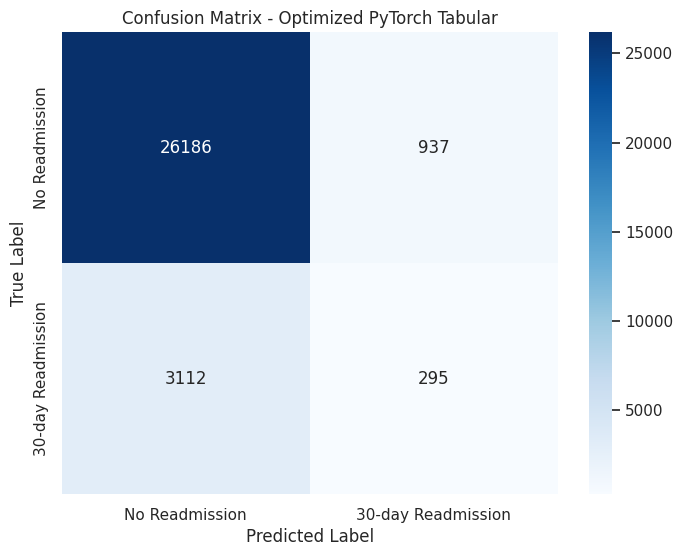


Confusion Matrix (PyTorch Tabular):
True Negatives: 26186
False Positives: 937
False Negatives: 3112
True Positives: 295


In [43]:
# Save the final PyTorch Tabular model
print("Saving PyTorch Tabular model...")

# Save the model
model_save_path = "best_pytorch_tabular_model"
final_model_pt.save_model(model_save_path)

# Also save the best hyperparameters
with open("best_pytorch_tabular_params.txt", "w") as f:
    f.write("Best PyTorch Tabular Hyperparameters:\n")
    f.write("="*50 + "\n")
    for key, value in study_pt.best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nBest CV Accuracy Score: {study_pt.best_value:.4f}\n")
    f.write(f"Final Test Accuracy Score: {final_accuracy_pt:.4f}\n")
    f.write(f"Final Test F1 Score: {final_f1_pt:.4f}\n")
    f.write(f"Final Test ROC-AUC: {final_auc_pt:.4f}\n")

print("Model and parameters saved successfully")

# Create confusion matrix for PyTorch Tabular
cm_pt = confusion_matrix(y_test_pt, final_pred_pt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized PyTorch Tabular')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix (PyTorch Tabular):")
print(f"True Negatives: {cm_pt[0,0]}")
print(f"False Positives: {cm_pt[0,1]}")
print(f"False Negatives: {cm_pt[1,0]}")
print(f"True Positives: {cm_pt[1,1]}")

* The results have slightly worse accuracy than in XGBOOST method. However, the higher recall makes it relatively safer to implement.

In [44]:
# Compare XGBoost and PyTorch Tabular results
print("="*60)
print("MODEL COMPARISON: XGBoost vs PyTorch Tabular")
print("="*60)

# print("\nCross-Validation Results (4-fold accuracy scores):")
# print(f"XGBoost CV Accuracy:         {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")
# print(f"PyTorch Tabular CV Accuracy: {np.mean(final_cv_scores_pt):.3f} ± {np.std(final_cv_scores_pt):.3f}")

print(f"\nTest Set Performance:")
print(f"{'Metric':<15} {'XGBoost':<10} {'PyTorch Tabular':<15}")
print("-" * 40)
print(f"{'Accuracy':<15} {test_accuracy:.3f}      {final_accuracy_pt:.3f}")
print(f"{'Precision':<15} {test_precision:.3f}      {final_prec_pt:.3f}")
print(f"{'Recall':<15} {test_recall:.3f}      {final_rec_pt:.3f}")
print(f"{'F1':<15} {test_f1:.3f}      {final_f1_pt:.3f}")
print(f"{'ROC-AUC':<15} {test_auc:.3f}      {final_auc_pt:.3f}")

print(f"\nBest Hyperparameters:")
print(f"\nXGBoost:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
    
print(f"\nPyTorch Tabular:")
for key, value in study_pt.best_params.items():
    print(f"  {key}: {value}")

print("\n" + "="*60)

MODEL COMPARISON: XGBoost vs PyTorch Tabular

Test Set Performance:
Metric          XGBoost    PyTorch Tabular
----------------------------------------
Accuracy        0.887      0.867
Precision       0.514      0.239
Recall          0.056      0.087
F1              0.101      0.127
ROC-AUC         0.783      0.655

Best Hyperparameters:

XGBoost:
  n_estimators: 677
  max_depth: 5
  learning_rate: 0.0788904684410345
  subsample: 0.8244269635087204
  colsample_bytree: 0.7905921798819306
  reg_alpha: 0.7023795461588158
  reg_lambda: 0.4852405347816829

PyTorch Tabular:
  layers_depth: 2
  layer_size: 64
  dropout: 0.28964204367349417
  learning_rate: 0.007697743501549193
  batch_size: 1024
  activation: LeakyReLU



* While the accuracy is good, its low recall might make the model unsuitable for deployment yet.

## Model interpretation
* We will use SHAP, a model-agnostic technique to analyze feature contributions the the output.

Performing SHAP analysis on the optimized XGBoost model...
SHAP values computed for 5000 samples


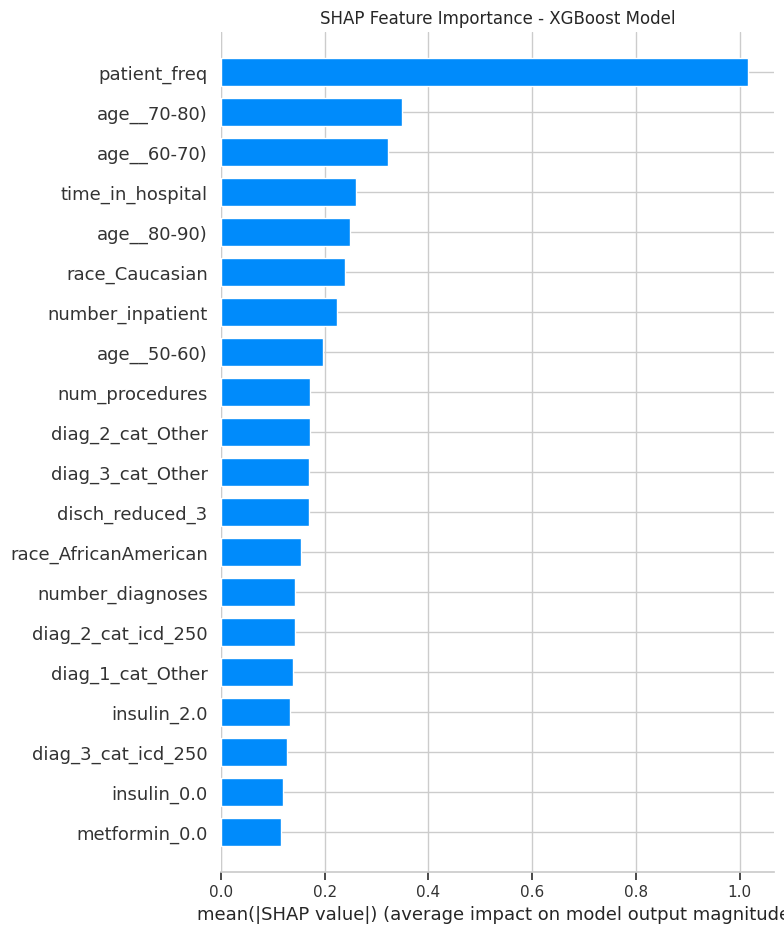

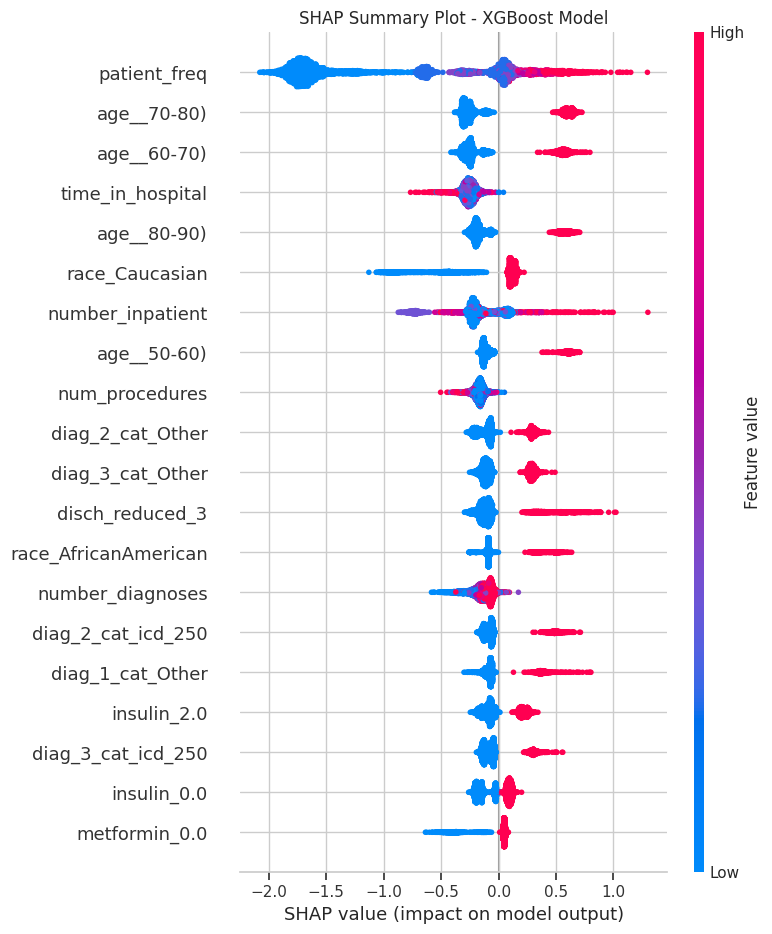


Top 15 Most Important Features (SHAP):
                  feature  importance
8            patient_freq    1.015283
29            age__70-80)    0.348936
28            age__60-70)    0.321540
0        time_in_hospital    0.259622
30            age__80-90)    0.248698
18         race_Caucasian    0.238597
6        number_inpatient    0.224410
27            age__50-60)    0.197463
2          num_procedures    0.172603
343      diag_2_cat_Other    0.171557
492      diag_3_cat_Other    0.169726
10        disch_reduced_3    0.169525
16   race_AfricanAmerican    0.154150
7        number_diagnoses    0.142598
344    diag_2_cat_icd_250    0.142366


In [45]:
# SHAP Analysis for XGBoost Model
print("Performing SHAP analysis on the optimized XGBoost model...")

# Get the XGBoost classifier from the best pipeline
xgb_model = best_pipeline.named_steps['classifier']

# Use a sample of training data for SHAP (to speed up computation)
sample_size = 5000
sample_indices = np.random.choice(X_train.shape[0], size=min(sample_size, X_train.shape[0]), replace=False)
X_sample = X_train.iloc[sample_indices]

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed for {len(X_sample)} samples")

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - XGBoost Model')
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot - XGBoost Model')
plt.tight_layout()
plt.show()

# Feature importance ranking
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_sample.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (SHAP):")
print(importance_df.head(15))

In [67]:
from sklearn.inspection import permutation_importance

class ModelWrapper:
    def __init__(self, model):
        self.model = model
    
    def predict(self, X):
        # Get predictions and ensure they're 1D integer array
        preds = self.model.predict(X)  # Use self.model, not final_model_pt
        pred_values = preds["target_prediction"].values  # Extract values and assign to variable
        return pred_values.astype(int)  # Return the extracted values, not the whole DataFrame
    
    def fit(self, X, y):
        # This is required by sklearn but we don't need to do anything
        # since our model is already trained
        return self

# Create the wrapper
wrapped_model = ModelWrapper(final_model_pt)

result = permutation_importance(wrapped_model, train_df_pt, y_train_pt, scoring='accuracy', n_repeats=10, random_state=1803)
importance_df = pd.DataFrame({
    'feature': train_df_pt.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

In [68]:
importance_df

,feature,importance
0,encounter_id,0.140300
1,patient_nbr,0.053613
7,discharge_disposition_id,0.001407
47,diag_1_cat,0.000059
49,diag_3_cat,0.000031
33,miglitol,0.000027
29,tolbutamide,0.000021
48,diag_2_cat,0.000018
16,number_emergency,0.000015
11,medical_specialty,0.000015


In [69]:
result_xgboost = permutation_importance(xgb_model, X_train, y_train, scoring='accuracy', n_repeats=10, random_state=1803)


KeyboardInterrupt: 

In [ ]:
importance_df_xgboost = pd.DataFrame({
    'feature': train_df_pt.columns,
    'importance': result_xgboost.importances_mean
}).sort_values(by='importance', ascending=False)

In [ ]:
importance_df_xgboost

### As of now we will not be implementing SHAP on the Pytorch Model as I am encountering compatibility issues between SHAP and Pytorch Tabular model.

In [46]:
# Reload the best PyTorch Tabular model
# print("Reloading the best PyTorch Tabular model...")

# # Load the saved model
# final_model_pt = TabularModel.load_model("best_pytorch_tabular_model")

# print("Model reloaded successfully!")

In [ ]:
# train_df_pt_float = train_df_pt.astype(np.float32)
# # keep the feature order you trained with
# FEATURE_NAMES = train_df_pt_float.columns.tolist()

# def pytorch_tabular_predict_proba(X):
#     """
#     SHAP wrapper for PyTorch-Tabular.
#     Ensures the incoming object is a pandas.DataFrame
#     with the correct column names and dtypes.
#     Returns the positive-class probability reshaped for SHAP.
#     """

#     pred_proba = final_model_pt.predict(X)

#     # keep only P(y=1) and give SHAP a 2-D array
#     return pred_proba["target_1_probability"].to_numpy().reshape(-1, 1)

# # ───  A.  Summarise the background  ────────────────────────────────────────────

# dense_bg   = shap.kmeans(train_df_pt_float, k=100)             # DenseData (not callable)
# masker     = shap.maskers.Independent(dense_bg.data)    # <-- make it callable


MemoryError: Unable to allocate 92.3 GiB for an array with shape (173995, 71236) and data type object

In [ ]:
# # ───  B.  Build the explainer  ────────────────────────────────────────────────
# explainer_pt = shap.Explainer(
#     pytorch_tabular_predict_proba,  # returns *logits*, see previous answer
#     masker,
#     link=shap.links.logit,                   # tell SHAP what the wrapper outputs
#     algorithm="permutation"         # same default the auto-chooser would pick
# )

In [ ]:
# # ───  C.  Explain a subset  ───────────────────────────────────────────────────

# sample_size     = 500
# sample_indices  = np.random.choice(len(train_df_pt_float),
#                                    size=min(sample_size, len(train_df_pt_float)),
#                                    replace=False)

# X_sample_pt     = train_df_pt_float.iloc[sample_indices]
# shap_values_pt = explainer_pt(X_sample_pt, max_evals=1300)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# shap.summary_plot(shap_values_pt.values, features=X_sample_pt,
#                   feature_names=X_sample_pt.columns, show=False)

In [ ]:
# # Feature importance ranking for PyTorch Tabular
# feature_importance_pt = np.abs(shap_values_pt).mean(0)
# feature_names_pt = X_sample_pt.columns
# importance_df_pt = pd.DataFrame({
#     'feature': feature_names_pt,
#     'importance': feature_importance_pt.ravel()
# }).sort_values('importance', ascending=False)

# print("\nTop 60 Most Important Features (SHAP - PyTorch Tabular):")
# importance_df_pt.head(60).to_csv('pytorch_tabular_shap_importance.csv', index=False)